<a href="https://colab.research.google.com/github/rahmanaul/textBlob-Sentiment-Analysis/blob/main/Vaksin_Sinovac_TextBlob_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
# sentiment Analisis 

In [2]:
#import libraries
import tweepy

from textblob import TextBlob as tb
from subprocess import check_output
from wordcloud import WordCloud, STOPWORDS

import pandas as pd
import numpy as np
import re
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

!pip install PySastrawi
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

plt.style.use('fivethirtyeight')
import json

!pip install googletrans==4.0.0-rc1
from googletrans import Translator

     |████████████████████████████████| 215kB 7.8MB/s 
     |████████████████████████████████| 61kB 3.5MB/s 
     |████████████████████████████████| 51kB 4.7MB/s 
     |████████████████████████████████| 1.0MB 12.6MB/s 
     |████████████████████████████████| 61kB 4.4MB/s 
     |████████████████████████████████| 71kB 7.4MB/s 
     |████████████████████████████████| 102kB 5.3MB/s 
  Created wheel for googletrans: filename=googletrans-4.0.0rc1-cp36-none-any.whl size=17417 sha256=40505d61758655238310a27a99e02259e50e46e7ed73d491046af57a29374fb7
  Stored in directory: /root/.cache/pip/wheels/09/32/56/fd8940f1b3c1d77c9f91b55597c52a4d4833b000a980bb0740
  Created wheel for contextvars: filename=contextvars-2.4-cp36-none-any.whl size=7667 sha256=2862dc87067de20107a31a9acfbde9db6937df8cd7b86ab2244e044f4aabb63c
  Stored in directory: /root/.cache/pip/wheels/a5/7d/68/1ebae2668bda2228686e3c1cf16f2c2384cea6e9334ad5f6de
Successfully built googletrans contextvars


In [3]:
# Load the Data
from google.colab import files
uploaded = files.upload()

Saving login.csv to login.csv


In [4]:
#Get the data
log = pd.read_csv('login.csv')

In [5]:
#Twiter API credentials
consumerKey = log['key'][0]
consumerSecret = log['key'][1]
accessToken = log['key'][2]
accessTokenSecret = log['key'][3]

In [6]:
# Create the Authentication objaect
authenticate = tweepy.OAuthHandler(consumerKey, consumerSecret)

#Set the access token and access toke secret
authenticate.set_access_token(accessToken, accessTokenSecret)

#Create the Api Object while passing in the auth info
api = tweepy.API(authenticate, wait_on_rate_limit=True)

In [32]:
search_words = "vaksin OR sinovac -filter:retweets"

tweets = api.search(
              q=search_words,
              lang="id",
              count=100,
              result_type="recent",
              tweet_mode="extended")

# Print the last 5 tweets from query
print("Show 5 Recent Tweets : \n")
i=1
for tweet in tweets[0:5]:
  print(str(i) + ') '+ tweet.full_text + '\n')
  i += 1

Show 5 Recent Tweets : 

1) Vaksin penting untuk mundung https://t.co/ACXQ0dXCKJ

2) Macam mana laa kau boleh percaya iphone 11 bawah 2K pastu buy 1 free 1 . Vaksin tak percaya pulak haih https://t.co/KkmuXd0MB2

3) Jadi tadi sore tuh aing mau COD tp malah di php sama si penjual husky umur 2 bulan dah vaksin no stb (biar murah hehe). Blgnya sih bkn petshop jd rumahan gitu trs janjian lah disini. Tp udh sejam lebih aing nunggu ga nongol2 anjing si penjual anjingnya. Kesel sih anjing tapi https://t.co/WXYKAD5UwY

4) Ustad rasis curiga kalo divaksin..

“Apalagi saya begini yang menentang-nentang kafir. Begitu dokternya dokter Kristen, aha, ini dia. Memang ditunggu-tunggu kau. Bukan disuntik vaksin, saya malah disuntik mati,” katanya.

Saya kok malah seneng ya kalo dia disuntik mati😅😅😅 https://t.co/7BQ8OVNf8A

5) @Husen_Jafar Kata ayah mertua vaksin itu konspirasi global..apakah benar ya bib?



In [34]:
#Create dataframe
df= pd.DataFrame([tweet.full_text for tweet in tweets], columns=['Tweets'])

#shiw first five row
df.head()


,Tweets
0,Vaksin penting untuk mundung https://t.co/ACXQ...
1,Macam mana laa kau boleh percaya iphone 11 baw...
2,Jadi tadi sore tuh aing mau COD tp malah di ph...
3,Ustad rasis curiga kalo divaksin..\n\n“Apalagi...
4,@Husen_Jafar Kata ayah mertua vaksin itu konsp...


In [36]:
# Menghilangkan Duplikat
df = df.drop_duplicates(subset='Tweets', keep='first').reset_index()
df.shape

(100, 2)

In [12]:
#import kamus alay dan Stopword bahasa indonesia
from google.colab import files
uploaded = files.upload()

Saving stopwordbahasa.csv to stopwordbahasa.csv


In [37]:
#Slang Word Replacement

slang_dict = pd.read_csv('new_kamusalay.csv', encoding='latin-1', header=None)
slang_dict = slang_dict.rename(columns={0: 'original', 
                                      1: 'replacement'})

id_stopword_dict = pd.read_csv('stopwordbahasa.csv', header=None)
id_stopword_dict = id_stopword_dict.rename(columns={0: 'stopword'})
stopwords_new = pd.DataFrame(['sih','nya', 'iya', 'nih', 'biar', 'tau', 'kayak', 'banget'], columns=['stopword'])
id_stopword_dict = pd.concat([id_stopword_dict,stopwords_new]).reset_index()
id_stopword_dict = pd.DataFrame(id_stopword_dict['stopword'])

In [38]:
slang_dict.head()

,original,replacement
0,anakjakartaasikasik,anak jakarta asyik asyik
1,pakcikdahtua,pak cik sudah tua
2,pakcikmudalagi,pak cik muda lagi
3,t3tapjokowi,tetap jokowi
4,3x,tiga kali


In [39]:
id_stopword_dict.head()

,stopword
0,ada
1,adalah
2,adanya
3,adapun
4,agak


In [40]:
#Stemmer, link, char, dan beberapa kata ganti

factory = StemmerFactory()
stemmer = factory.create_stemmer()


def lowercase(text):
    return text.lower()

def remove_unnecessary_char(text):
    text = re.sub(r'pic.twitter.com.[\w]+', '', text) # Remove every pic 
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))',' ',text) # Remove every URL
    
    text = re.sub('gue','saya',text) # Sub gue saya
    text = re.sub('\n',' ',text) # Remove every '\n'
    
    text = re.sub(r'[^\x00-\x7F]+',' ', text)
    text = re.sub(r':', '', text)
    text = re.sub(r'‚Ä¶', '', text)
    
    to_delete = ['hypertext', 'transfer', 'protocol', 'over', 'secure', 'socket', 'layer', 'dtype', 'tweet', 'name', 'object'
                 ,'twitter','com', 'pic', ' ya ']
    
    for word in to_delete:
        text = re.sub(word,'', text)
        text = re.sub(word.upper(),' ',text)
    
    retweet_user = [' rt ', ' user ']
    
    for word in retweet_user:
        text = re.sub(word,' ',text) # Remove every retweet symbol & username
        text = re.sub(word.upper(),' ',text)
        
    text = re.sub('  +', ' ', text) # Remove extra spaces
    return text
    
def remove_nonaplhanumeric(text):
    text = re.sub('[^0-9a-zA-Z]+', ' ', text) 
    return text

slang_dict_map = dict(zip(slang_dict['original'], slang_dict['replacement']))

def normalize_slang(text):
    return ' '.join([slang_dict_map[word] if word in slang_dict_map else word for word in text.split(' ')])

def remove_stopword(text):
    text = ' '.join(['' if word in id_stopword_dict.stopword.values else word for word in text.split(' ')])
    text = re.sub('  +', ' ', text) # Remove extra spaces
    text = text.strip()
    return text

def stemming(text):
    return stemmer.stem(text)

In [41]:
def preprocess(text):
    text = lowercase(text)
    text = remove_unnecessary_char(text)
    text = remove_nonaplhanumeric(text)
    text = normalize_slang(text)
    text = stemming(text) 
    text = remove_stopword(text)
    return text

In [43]:
df['Tweets'] = df['Tweets'].apply(preprocess).apply(preprocess)

In [44]:
df = df.drop_duplicates(subset='Tweets', keep='first').reset_index()
df.shape

(100, 3)

In [45]:
df.to_csv('vaksin-pemerintah-preprocessed.csv', index=False)

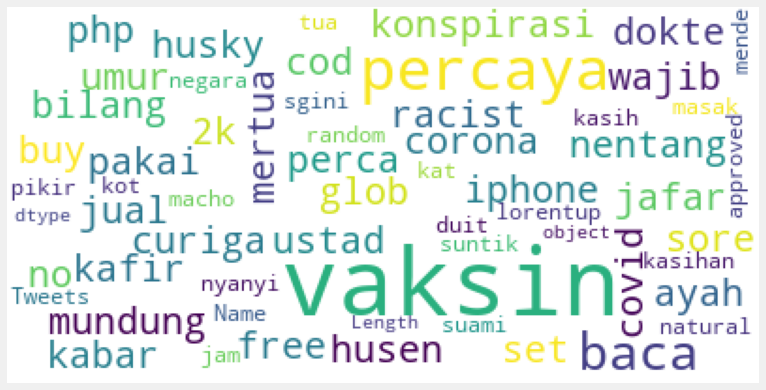

In [64]:
mpl.rcParams['figure.figsize']=(12.0,12.0) 
mpl.rcParams['font.size']=12              
mpl.rcParams['savefig.dpi']=100             
mpl.rcParams['figure.subplot.bottom']=.1 


stopwords = set(STOPWORDS)

wordcloud = WordCloud(
                          background_color='white',
                          stopwords=id_stopword_dict,
                          max_words=400,
                          max_font_size=50, 
                          random_state=21
                         ).generate(str(df['Tweets']))

print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()
fig.savefig("word1.png", dpi=900)

In [22]:
translator = Translator()
translator.translate('nice', dest='id').text

'bagus'

In [49]:
  def en_to_id(sentence):
    if tb(sentence).detect_language() == 'en':
        return tb(sentence)
    
    translator = Translator()
    
    output = translator.translate(sentence, dest='en')
    return tb(output.text)
    
def get_sentiment(sentence):
    sentence = en_to_id(sentence)
    return sentence.sentiment

def round_polarity(value):
    if value >= 0.3:
        return 1
    elif value == 0:
        return 0
    return -1

def round_subjectivity(value):
    if value >= 0:
        return 1
    elif value == 0:
        return 0
    return -1

In [75]:
tweets = df['Tweets']
polarity = []
subjectivity = []

for tweet in tweets:
    sentiment = get_sentiment(tweet)
    #print(sentiment)
    polarity.append(sentiment[0])
    subjectivity.append(sentiment[1])

In [76]:
df['Subjectivity'] = subjectivity
df['Polarity'] = polarity

In [79]:
df

,level_0,index,Tweets,Subjectivity,Polarity,Analysis
0,0,0,vaksin mundung,0.0,0.00,Neutral
1,1,1,percaya iphone 11 2k buy 1 free 1 vaksin perca...,0.8,0.40,Positive
2,2,2,sore cod php jual husky umur 2 vaksin no set t...,0.6,-0.05,Negative
3,3,3,ustad racist curiga vaksin nentang kafir dokte...,0.4,-0.20,Negative
4,4,4,husen jafar ayah mertua vaksin konspirasi glob...,0.0,0.00,Neutral
...,...,...,...,...,...,...
95,95,95,vaksin wajib kabar bilang corona covid pakai s...,0.0,0.00,Neutral
96,96,96,lorentup macho kasih duit vaksin kasihan,0.4,0.20,Positive
97,97,97,vaksin percaya masak nyanyi suami tua percaya,0.2,0.10,Positive
98,98,98,random jam sgini baca baca vaksin pikir suntik...,0.4,-0.15,Negative


In [78]:
#create a function to compute the negative , neutral and positive analysis
def getAnalysis(score):
  if score < 0:
    return 'Negative'
  elif score == 0:
    return 'Neutral'
  else:
    return 'Positive'

df['Analysis'] = df['Polarity'].apply(getAnalysis)
df

,level_0,index,Tweets,Subjectivity,Polarity,Analysis
0,0,0,vaksin mundung,0.0,0.00,Neutral
1,1,1,percaya iphone 11 2k buy 1 free 1 vaksin perca...,0.8,0.40,Positive
2,2,2,sore cod php jual husky umur 2 vaksin no set t...,0.6,-0.05,Negative
3,3,3,ustad racist curiga vaksin nentang kafir dokte...,0.4,-0.20,Negative
4,4,4,husen jafar ayah mertua vaksin konspirasi glob...,0.0,0.00,Neutral
...,...,...,...,...,...,...
95,95,95,vaksin wajib kabar bilang corona covid pakai s...,0.0,0.00,Neutral
96,96,96,lorentup macho kasih duit vaksin kasihan,0.4,0.20,Positive
97,97,97,vaksin percaya masak nyanyi suami tua percaya,0.2,0.10,Positive
98,98,98,random jam sgini baca baca vaksin pikir suntik...,0.4,-0.15,Negative


In [80]:
# Print all of the positive tweets
j = 1
sortedDF = df.sort_values(by=['Polarity'])
for i in range(0, sortedDF.shape[0]):
  if (sortedDF['Analysis'][i] == 'Positive'):
    print(str(j) + ') ' + sortedDF['Tweets'][i])
    print()
    j = j+1

1) percaya iphone 11 2k buy 1 free 1 vaksin percaya haiz

2) kareladipria stok vaksin dunia batas rel nomor antre usaha nyalip antre institusi negara ajaib usaha lokal badan usaha milik negara

3) vaksin kandung bahan bahaya vaksincovid19 vaksinasinasional yukvaksin vaksinuntukkita vaksinsiap34propinsi

4) haikal hasan suntik vaksin covid 19 waras vaksin waras full

5) vaksin percaya mak letak ikan bekas ice cream percaya lmao i tried

6) subtanyarl kali pingsan pas habis suntik vaksin disklh muntah2 langsung lemas tb2 langsung gelap dengar suara orang orang pikir kyallah hamba eh nyata pasitu sadar pingsan

7) orang remind latest iphone 2k vaksin percaya harga iphone murah buy 1 free 1 percaya

8) usaha beli gratis vaksin karyawannya jual

9) vaksin jamin selamat efektif pkp pkpp pkpb kitateguhkitamenang komunikasikita psacovid19rtm

10) bayar vaksin anggar belanja negara swasta gratis vaksin jual rakyat maling

11) i have witnessed multitude of efforts made nyelenggarain vaksin orang

In [81]:
# Print all of the Negative tweets
j = 1
sortedDF = df.sort_values(by=['Polarity'], ascending='False')
for i in range(0, sortedDF.shape[0]):
  if (sortedDF['Analysis'][i] == 'Negative'):
    print(str(j) + ') ' + sortedDF['Tweets'][i])
    print()
    j = j+1

1) sore cod php jual husky umur 2 vaksin no set top box murah hehe bilang petshop rumah janji jam tunggu nongol2 anjing jual anjing kesal anjing

2) ustad racist curiga vaksin nentang kafir dokter dokter kristen aha tunggu tunggu suntik vaksin suntik mati senengkalo suntik mati

3) subtanyarl pusing habis vaksin sekolah tegang muk pingsan

4) kali coba pindah dokter kemarin habis vaksin seminggian langsung muntah muntah nafsu makan sok far bocanya kasihan mas kemarin meganging kena gigit darah hiks ganas orang

5) serius guys vaksin nyata apply usia

6) tywerdsz vaksin bangkang bangkang raja takut kena vaksin

7) fakta vaksin cegah sakit bawa maut vaksincovid19 komunikasikita jabatanpenerangan

8) cr1st1n ntali3e cinihiya alas pirang sakit perut suka baris serba garda jaga ulama kiyai nu moga cepat vaksinbiar cepat sembuh behahaha

9) polisi orang sombong pakai masker provokator program vaksin perintah urus polisi yahya waloni takut hadap aparat divhumas polisi republik indonesia ccicp

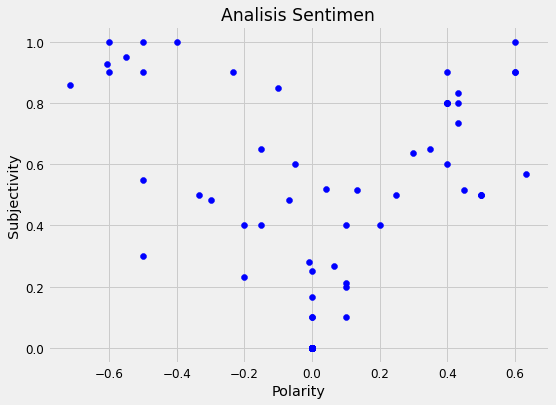

In [82]:
#plot Polarity and Subjectivity
plt.figure(figsize=(8,6))
for i in range(0, df.shape[0]):
  plt.scatter(df['Polarity'][i], df['Subjectivity'][i], color='Blue')

plt.title('Analisis Sentimen')
plt.xlabel('Polarity')
plt.ylabel('Subjectivity')
plt.show()

In [83]:
#Get the Precentage of Positive tweets
ptweets = df[df.Analysis == 'Positive']
ptweets = ptweets['Tweets']

round((ptweets.shape[0] / df.shape[0]) * 100, 1)

28.0

In [86]:
#Get the Precentage of Negative tweets
ntweets = df[df.Analysis == 'Negative']
ntweets = ntweets['Tweets']

round((ntweets.shape[0] / df.shape[0] * 100), 1)

21.0

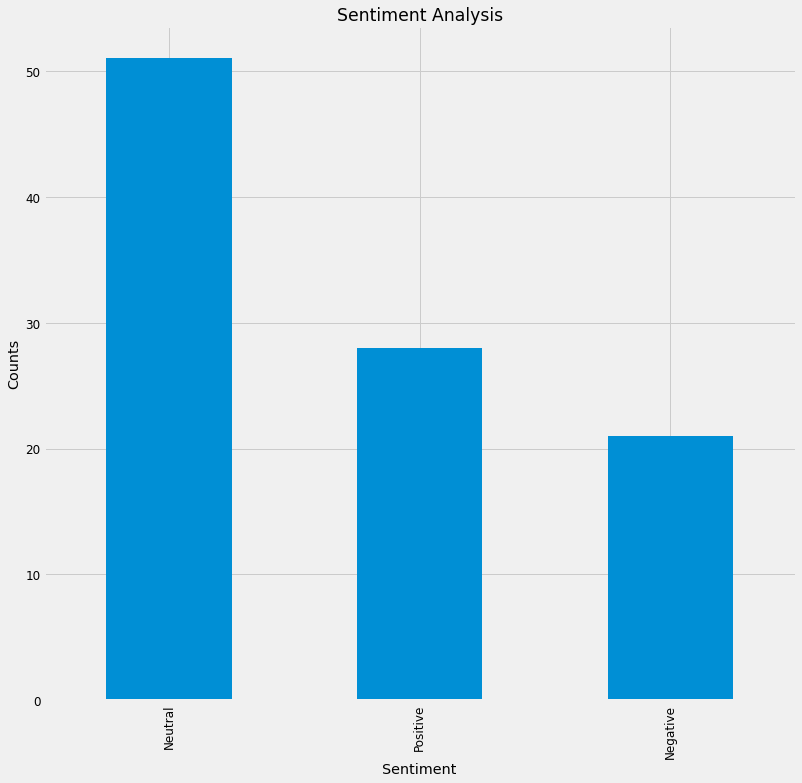

In [87]:
#Show the Value Counts

df['Analysis'].value_counts()

#plot and visualize the counts
plt.title('Sentiment Analysis')
plt.xlabel('Sentiment')
plt.ylabel('Counts')
df['Analysis'].value_counts().plot(kind='bar')
plt.show()

Dari Hasil Kesimulan terlihat dari 100 tweet berbahasa indonesia Mayoritas Netral terhadap Vaksin Sinovac dan pemerintah